# Customer & Sales Analytics 
## Exploratory Data Analysis (EDA)

### Purpose of This Analysis 
This notebook performs **exploratory data analysis** on the processed order-level master table to understand **sales trends, customer behaviour, delivery performance, and customer satisfaction**.

The insights from this analysis will guide:
- **RFM-based customer segmentation**
- **Sales forecasting model selection**
- **Churn prediction feature design**

The notebook focuses on **exploration and insights generation**, serving as a foundation for modelling and final business recommendation.

In [1]:
# exploratory data analysis (EDA)

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Load processed master table

master_df = pd.read_csv(
    "OneDrive/Documents/Customer Sales Analytics/master_table_processed.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ]
)

print(f"Dataset shape: {master_df.shape}")
print(
    f"Date range: {master_df['order_purchase_timestamp'].min()} → "
    f"{master_df['order_purchase_timestamp'].max()}"
)

Dataset shape: (96478, 39)
Date range: 2016-09-15 12:16:38 → 2018-08-29 15:00:37


In [3]:
master_df.head(4)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_month,order_day_of_week,is_weeknd,year_month,avg_item_price,freight_percentage,satisfaction_score,is_weekend,is_extreme_delay,delivery_time_days_capped
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,10,0,0,2017-10,29.99,22.526479,4.0,0,0,8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,7,1,0,2018-07,118.70,16.089354,4.0,0,0,13.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,8,2,0,2018-08,159.90,10.730237,5.0,0,0,9.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,11,5,1,2017-11,45.00,37.673130,5.0,1,0,13.0


# Sales Trends Over Time (Forecasting Insight)

### Monthly Sales Trends Insights
The monthly order volume exhibits a rapid growth phase followed by a period of stabilization, suggesting that the platform has moved beyond its initial expansion stage. In contrast, monthly revenue remains consistently high even as order volumes level off. This divergence indicates an improvement in order value rather than reliance solely on increased transaction counts.


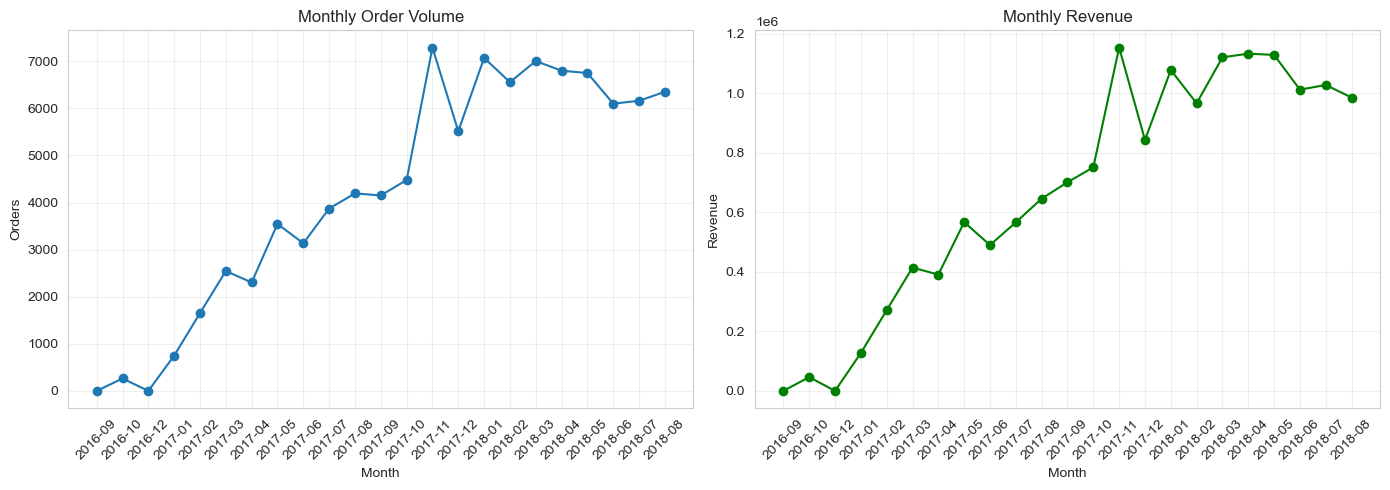

Total Revenue: $15,419,773.75
Average Monthly Revenue: $670,424.95
Peak Month: 2017-11


In [9]:
monthly_sales = (
    master_df
    .groupby("year_month")
    .agg(
        orders=("order_id","count"),
        revenue=("order_revenue","sum")
    )
    .reset_index()
)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# monthly order volume plot
ax[0].plot(monthly_sales["year_month"], monthly_sales["orders"], marker="o")
ax[0].set_title("Monthly Order Volume")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Orders")
ax[0].tick_params(axis="x", rotation=45)
ax[0].grid(True, alpha=0.3)

# monthly revenue plot
ax[1].plot(monthly_sales["year_month"], monthly_sales["revenue"], marker="o", color="green")
ax[1].set_title("Monthly Revenue")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Revenue")
ax[1].tick_params(axis="x", rotation=45)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total Revenue: ${monthly_sales['revenue'].sum():,.2f}")
print(f"Average Monthly Revenue: ${monthly_sales['revenue'].mean():,.2f}")
print(f"Peak Month: {monthly_sales.loc[monthly_sales['revenue'].idxmax(), 'year_month']}")

# Customer Order Behaviour 

### Customer Behaviour Insights
- Customer purchasing behavior is highly skewed. The majority of customers place only a single order, resulting in a low average order frequency of 1.03 orders per customer. Only 3% of customers are repeat buyers, indicating a high churn rate after the first purchase.
- Customer lifetime value is also unevenly distributed. While the average lifetime value is $165.17, most customers spend significantly less, and a small group of high-value customers disproportionately contributes to total revenue.




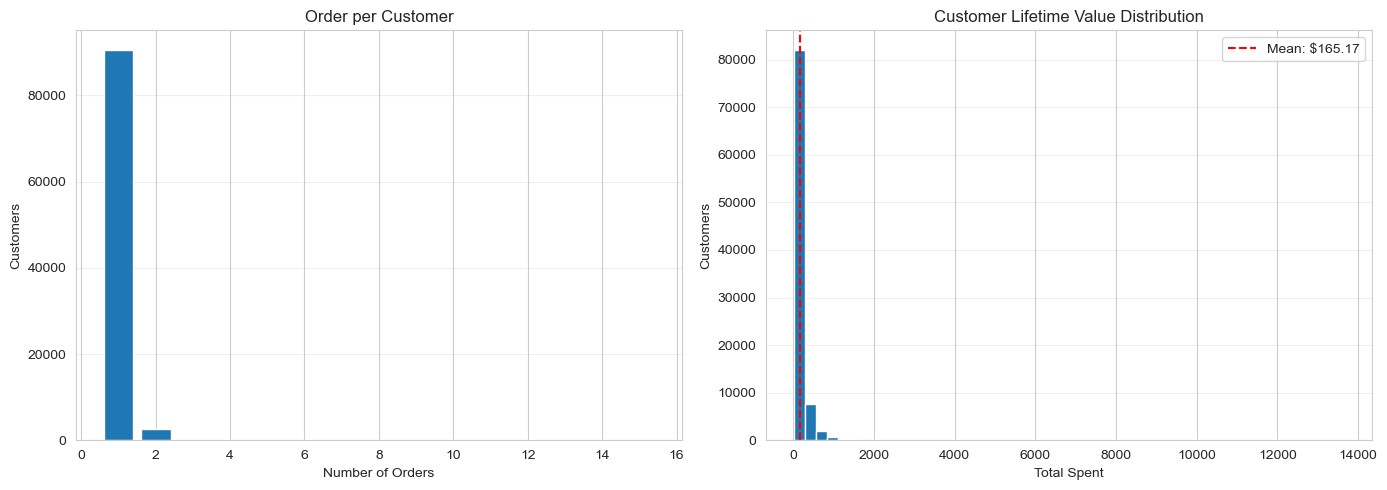

Total Customers: 93,358
Average Orders per Customer: 1.03
Average Customer Lifetime Value: $165.17
Repeat Customers: 2,801 (3.0%)


In [10]:
customer_summary = (
    master_df
    .groupby("customer_unique_id")
    .agg(
        num_orders=("order_id", "count"),
        total_spent=("order_revenue", "sum")
    )
    .reset_index()
)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

order_freq = customer_summary["num_orders"].value_counts().sort_index()
ax[0].bar(order_freq.index, order_freq.values)
ax[0].set_title("Order per Customer")
ax[0].set_xlabel("Number of Orders")
ax[0].set_ylabel("Customers")
ax[0].grid(axis="y", alpha=0.3)

ax[1].hist(customer_summary["total_spent"], bins=50)
ax[1].set_title("Customer Lifetime Value Distribution")
ax[1].set_xlabel("Total Spent")
ax[1].set_ylabel("Customers")
ax[1].axvline(
    customer_summary["total_spent"].mean(),
    color="red", linestyle="--",
    label=f"Mean: ${customer_summary['total_spent'].mean():.2f}"
)
ax[1].legend()
ax[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# Total customers
total_customers = customer_summary.shape[0]
print(f"Total Customers: {total_customers:,}")

# Average orders per customer
avg_orders_per_customer = customer_summary["num_orders"].mean()
print(f"Average Orders per Customer: {avg_orders_per_customer:.2f}")

# Average customer lifetime value
avg_clv = customer_summary["total_spent"].mean()
print(f"Average Customer Lifetime Value: ${avg_clv:,.2f}")

# Repeat customer percentage
repeat_customers = (customer_summary["num_orders"] > 1)
print(
    f"Repeat Customers: {repeat_customers.sum():,} "
    f"({repeat_customers.mean() * 100:.1f}%)"
)

# Delivery Performance Analysis

### Delivery Performance Insights
Most orders are delivered within a reasonable timeframe, with a median delivery time of 10 days. The average delivery time is slightly higher at 12.1 days, indicating a right-skewed distribution driven by a small number of delayed deliveries. Although late deliveries account for only 6.8% of total orders, their disproportionate impact on customer satisfaction makes delivery performance a critical factor for churn and retention analysis.


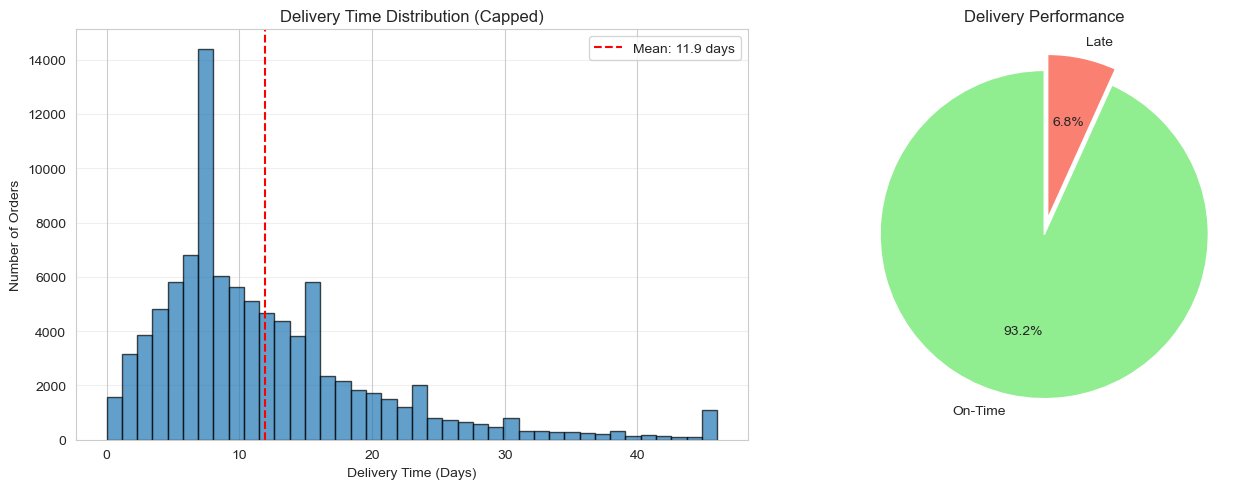

===== DELIVERY PERFORMANCE SUMMARY =====
Average Delivery Time: 12.1 days
Median Delivery Time: 10.0 days
Late Delivery Rate: 6.8%


In [11]:
# delivery performance analysis

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 1. Delivery time distribution
ax[0].hist(
    master_df["delivery_time_days_capped"],
    bins=40,
    edgecolor="black",
    alpha=0.7
)

ax[0].axvline(
    master_df["delivery_time_days_capped"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {master_df['delivery_time_days_capped'].mean():.1f} days"
)

ax[0].set_title("Delivery Time Distribution (Capped)")
ax[0].set_xlabel("Delivery Time (Days)")
ax[0].set_ylabel("Number of Orders")
ax[0].legend()
ax[0].grid(axis="y", alpha=0.3)

# 2. Late vs on-time delivery
late_counts = master_df["is_late_delivery"].value_counts()

ax[1].pie(
    late_counts,
    labels=["On-Time", "Late"],
    autopct="%1.1f%%",
    startangle=90,
    explode=(0, 0.1),
    colors=["lightgreen", "salmon"]
)

ax[1].set_title("Delivery Performance")

plt.tight_layout()
plt.show()

# summary statistics (PRINT)

avg_delivery_time = master_df["delivery_time_days"].mean()
median_delivery_time = master_df["delivery_time_days"].median()
late_delivery_rate = master_df["is_late_delivery"].mean() * 100

print("===== DELIVERY PERFORMANCE SUMMARY =====")
print(f"Average Delivery Time: {avg_delivery_time:.1f} days")
print(f"Median Delivery Time: {median_delivery_time:.1f} days")
print(f"Late Delivery Rate: {late_delivery_rate:.1f}%")

# Customer Satisfaction Analysis

### Customer Satisfaction Insights
Customer satisfaction is generally high, with nearly 59% of orders receiving a 5-star rating and an overall average score of 4.13. However, delivery performance has a substantial impact on customer experience. Orders delivered on time receive an average review score of 4.27, while late deliveries drop sharply to 2.22. This large decline highlights delivery reliability as a critical driver of dissatisfaction and a key predictor for customer churn.


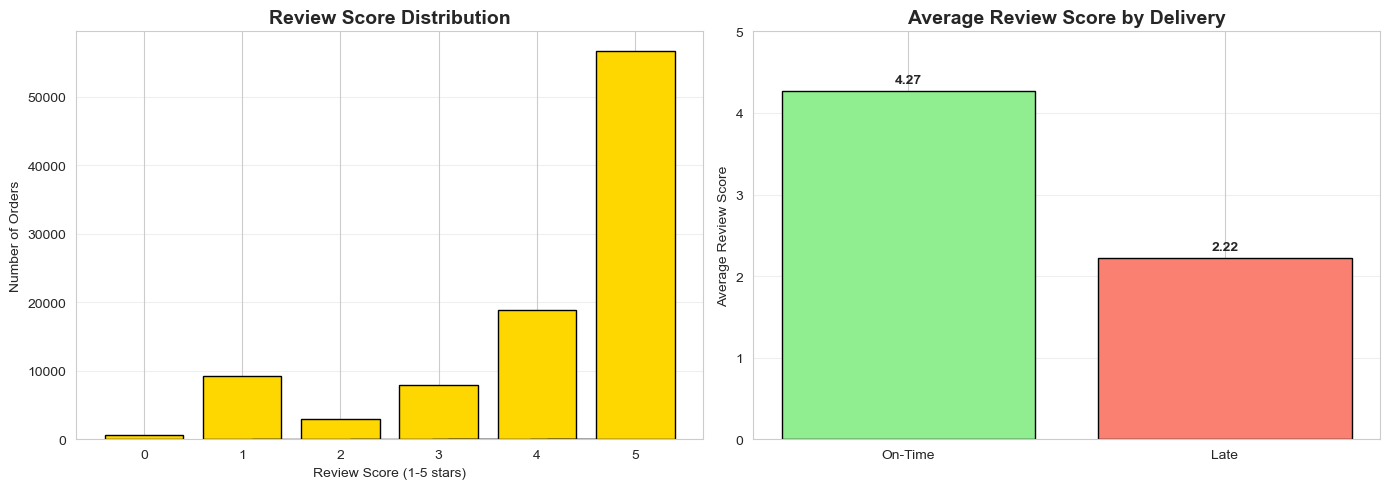

===== CUSTOMER SATISFACTION SUMMARY =====
Average Review Score: 4.13
5-Star Reviews: 58.8%
1-Star Reviews: 9.7%


In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Review score distribution
review_dist = master_df["review_score"].value_counts().sort_index()
ax[0].bar(review_dist.index, review_dist.values, 
          color="gold", edgecolor="black")
ax[0].set_title("Review Score Distribution", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Review Score (1-5 stars)")
ax[0].set_ylabel("Number of Orders")
ax[0].grid(axis="y", alpha=0.3)

# Satisfaction by delivery performance
satisfaction_by_delivery = (
    master_df
    .groupby("is_late_delivery")["review_score"]
    .mean()
)

delivery_labels = ["On-Time", "Late"]
colors = ["lightgreen", "salmon"]
bars = ax[1].bar(delivery_labels, satisfaction_by_delivery.values, 
                 color=colors, edgecolor="black")
ax[1].set_title("Average Review Score by Delivery", fontsize=14, fontweight="bold")
ax[1].set_ylabel("Average Review Score")
ax[1].set_ylim(0, 5)
ax[1].grid(axis="y", alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
               f'{satisfaction_by_delivery.values[i]:.2f}',
               ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# summary statistics

avg_review = master_df["review_score"].mean()
five_star_rate = (master_df["review_score"] == 5).mean() * 100
one_star_rate = (master_df["review_score"] == 1).mean() * 100

print("===== CUSTOMER SATISFACTION SUMMARY =====")
print(f"Average Review Score: {avg_review:.2f}")
print(f"5-Star Reviews: {five_star_rate:.1f}%")
print(f"1-Star Reviews: {one_star_rate:.1f}%")

# Order Value Distribution

### Order Value Insights
Order value distribution is highly right-skewed, with an average order value of 159.83 USD and a median of 105.28 USD. This gap indicates that a small number of high-value orders significantly influence overall revenue. Most orders consist of a single item, with an average of 1.14 items per order, suggesting that revenue growth is driven more by product pricing than basket size. These patterns reinforce the need for quantile-based monetary segmentation in RFM analysis.


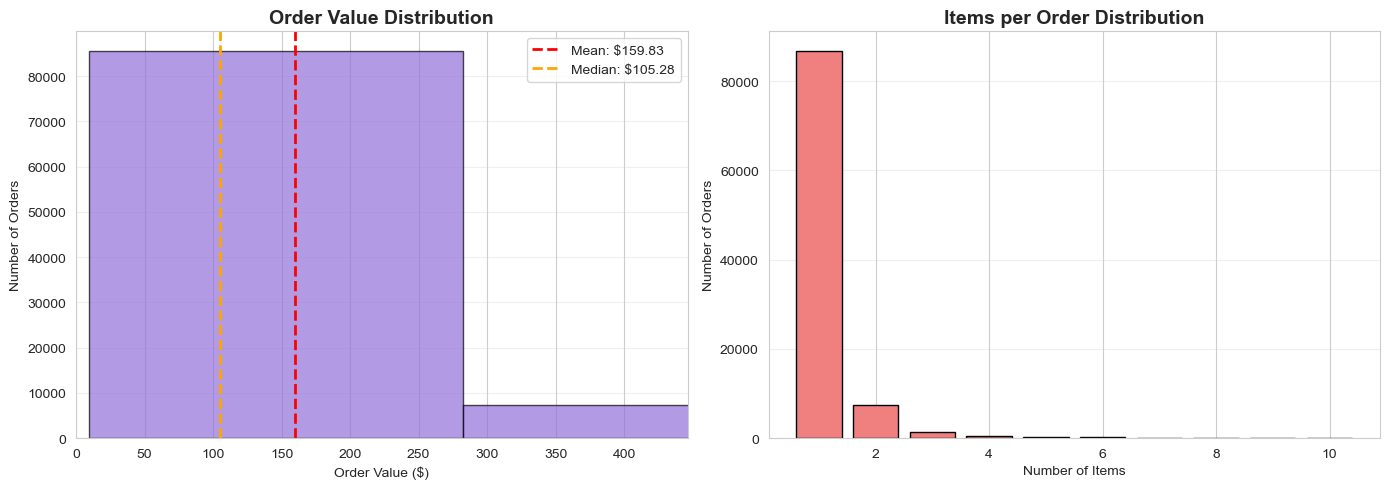

===== ORDER VALUE SUMMARY =====
Average Order Value: $159.83
Median Order Value: $105.28
Average Items per Order: 1.14


In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Order value distribution

ax[0].hist(master_df["order_revenue"], bins=50, 
           color="mediumpurple", alpha=0.7, edgecolor="black")

ax[0].axvline(master_df["order_revenue"].mean(), 
              color="red", linestyle="--", linewidth=2, 
              label=f"Mean: ${master_df['order_revenue'].mean():.2f}")

ax[0].axvline(master_df["order_revenue"].median(), 
              color="orange", linestyle="--", linewidth=2, 
              label=f"Median: ${master_df['order_revenue'].median():.2f}")

ax[0].set_title("Order Value Distribution", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Order Value ($)")
ax[0].set_ylabel("Number of Orders")
# focus on 95% of data to reduce extreme skew
ax[0].set_xlim(0, master_df["order_revenue"].quantile(0.95))
ax[0].legend()
ax[0].grid(axis="y", alpha=0.3)

# Items per order

items_dist = master_df["num_items"].value_counts().sort_index().head(10)
ax[1].bar(items_dist.index, items_dist.values, 
          color="lightcoral", edgecolor="black")

ax[1].set_title("Items per Order Distribution", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Number of Items")
ax[1].set_ylabel("Number of Orders")
ax[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# summary statistics
print("===== ORDER VALUE SUMMARY =====")
print(f"Average Order Value: ${master_df['order_revenue'].mean():.2f}")
print(f"Median Order Value: ${master_df['order_revenue'].median():.2f}")
print(f"Average Items per Order: {master_df['num_items'].mean():.2f}")

# Key Correlation Analysis

### Feature Correlation Insights
Correlation analysis confirms that delivery performance is a key driver of customer satisfaction. Longer delivery times and late deliveries show moderate to strong negative correlations with review scores, highlighting delivery reliability as a major factor influencing customer experience. Order revenue shows only weak correlation with delivery-related features, indicating that monetary value and operational performance are largely independent. These results support the combined use of delivery, satisfaction, and revenue features in customer segmentation and churn modeling.


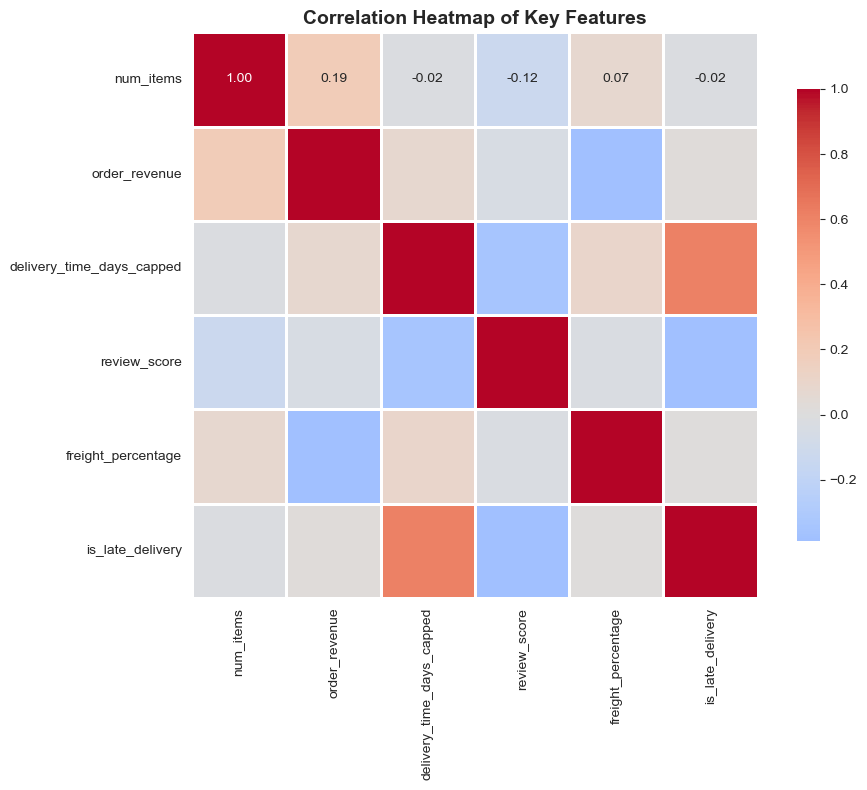

In [20]:
# key feature correlation

# Select only relevant numeric features
corr_features = [
    "num_items",
    "order_revenue",
    "delivery_time_days_capped",
    "review_score",
    "freight_percentage",
    "is_late_delivery"
]

corr_matrix = master_df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap of Key Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()